# Folha de Pagamento – Bolsa Atleta

Notebook do Trabalho Prático 2 – DCC011

## 2. Membros

- Marcos Alves de Castro Baker – 2024421657
- Victor Maia de Andrade — 2022105634
- Alexandre Lara Silveira Racilan - 2017093879

## 3. Descrição dos dados e processamento



In [3]:
# Detectar se está rodando no Google Colab ou localmente
try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    IN_COLAB = False
    print("Rodando localmente - Google Drive não será montado")

Rodando localmente - Google Drive não será montado


## Descrição dos Dados

Este notebook processa dados da **Folha de Pagamento – Bolsa Atleta**, originados do arquivo `bolsa_atleta.csv`. Os dados brutos foram carregados, limpos e padronizados, e então organizados em um banco de dados SQLite (`bolsa_atleta.db`) para melhor gestão e consulta.

### Dados Brutos (`bolsa_atleta.csv`)

O arquivo CSV original contém informações detalhadas sobre os pagamentos da Bolsa Atleta. As colunas principais são:

*   `Edital`: Edital ao qual o pagamento se refere.
*   `CPF`: CPF do atleta (anonimizado).
*   `Nome do Atleta`: Nome completo do atleta.
*   `Categoria`: Categoria do atleta (e.g., Atleta Nacional, Atleta Pódio).
*   `Modalidade`: Modalidade esportiva do atleta.
*   `Situação`: Situação do pagamento (e.g., Pago).
*   `Valor Pago`: Valor do pagamento da bolsa.
*   `Data de Pagamento`: Data em que o pagamento foi efetuado.
*   `Data de referência`: Mês e ano de referência para o pagamento.
*   `Municipio`: Município de residência do atleta.
*   `UF`: Unidade Federativa (estado) do atleta.

### Processamento e Limpeza

Durante a etapa de limpeza, foram realizadas as seguintes operações no DataFrame `df`:

*   **Renomeação de colunas**: Nomes das colunas foram padronizados para `snake_case` (e.g., `Nome do Atleta` para `nome`).
*   **Limpeza de strings**: Espaços em branco extras foram removidos de colunas textuais.
*   **Conversão de `valor_pago`**: A coluna `Valor Pago` foi convertida para tipo numérico (`float`), removendo caracteres como 'R$' e separadores de milhar (ponto) e substituindo a vírgula decimal por ponto.
*   **Conversão de datas**: As colunas `Data de Pagamento` e `Data de referência` foram convertidas para o tipo `datetime` para facilitar manipulações e consultas baseadas em tempo.

### Banco de Dados SQLite (`bolsa_atleta.db`)

O banco de dados SQLite foi criado com um modelo relacional normalizado para otimizar a integridade e eficiência das consultas. Ele é composto pelas seguintes tabelas:

*   **`municipio`**: Uma tabela de dimensão que armazena informações de município e estado.
    *   **id_municipio**: Chave primária.
    *   **municipio**: Nome do município.
    *   **uf**: Unidade Federativa (estado).

*   **`categoria`**: Uma tabela de dimensão para as diferentes categorias de atletas.
    *   **id_categoria**: Chave primária.
    *   **categoria**: Nome da categoria do atleta.

*   **`modalidade`**: Uma tabela de dimensão para as modalidades esportivas.
    *   **id_modalidade**: Chave primária.
    *   **modalidade**: Nome da modalidade esportiva.

*   **`situacao`**: Uma tabela de dimensão para as situações de pagamento.
    *   **id_situacao**: Chave primária.
    *   **situacao**: Descrição da situação do pagamento.

*   **`edital`**: Uma tabela de dimensão para os editais.
    *   **id_edital**: Chave primária.

*   **`atleta`**: Tabela principal para informações dos atletas.
    *   **cpf**: Chave primária (anonimizada).
    *   **nome**: Nome completo do atleta.
    *   **id_municipio**: Chave estrangeira para a tabela `municipio`.

*   **`pagamento`**: Tabela de fatos contendo os detalhes de cada pagamento da bolsa.
    *   **id_pagamento**: Chave primária, auto-incrementada.
    *   **cpf**: Chave estrangeira para a tabela `atleta`.
    *   **id_categoria**: Chave estrangeira para a tabela `categoria`.
    *   **id_modalidade**: Chave estrangeira para a tabela `modalidade`.
    *   **id_situacao**: Chave estrangeira para a tabela `situacao`.
    *   **id_edital**: Chave estrangeira para a tabela `edital`.
    *   **valor_pago**: O valor numérico do pagamento.
    *   **data_pagamento**: Data exata do pagamento.
    *   **data_referencia**: Data de referência para o pagamento (geralmente início do mês).

Essa estrutura normalizada permite consultas eficientes e garante a integridade dos dados, evitando redundâncias e inconsistências.

### 3.1 Imports e funções auxiliares

In [5]:
import pandas as pd
import sqlite3
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Deixe o display mais amigável no notebook
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 120)

def fetch(query: str, conn: sqlite3.Connection, formatted: bool = True):
    """Executa uma consulta SQL e retorna um DataFrame com o resultado.
    
    Args:
        query: Consulta SQL a ser executada
        conn: Conexão com o banco de dados SQLite
        formatted: Se True, retorna DataFrame; se False, retorna lista de tuplas
    
    Returns:
        DataFrame ou lista de tuplas dependendo do parâmetro formatted
    """
    cur = conn.cursor()
    cur.execute(query)
    rs = cur.fetchall()
    
    # Extrai nomes das colunas da descrição do cursor
    columns = [desc[0] for desc in cur.description]
    
    # Retorna DataFrame com nomes de colunas se formatted=True, senão retorna lista de tuplas
    return pd.DataFrame(rs, columns=columns) if formatted else rs

def show_tables(conn: sqlite3.Connection):
    """Lista todas as tabelas do banco de dados."""
    return [x[0] for x in fetch('SELECT tbl_name FROM sqlite_master WHERE type="table"', conn, False)]

def shape(table: str, conn: sqlite3.Connection):
    """Retorna o número de linhas e colunas de uma tabela (análogo ao pandas .shape)."""
    nrows = fetch(f'SELECT COUNT(*) FROM "{table}"', conn, False)[0][0]
    ncols = fetch(f'SELECT COUNT(*) FROM pragma_table_info("{table}")', conn, False)[0][0]
    return (nrows, ncols)

def desc(table: str, conn: sqlite3.Connection):
    """Retorna lista de nomes das colunas de uma tabela."""
    cur = conn.cursor()
    cur.execute(f'PRAGMA table_info("{table}")')
    columns = [row[1] for row in cur.fetchall()]
    return columns

def info(table: str, conn: sqlite3.Connection):
    """Retorna informações detalhadas sobre uma tabela (análogo ao pandas .info() / .nunique()).
    
    Retorna DataFrame com:
    - Informações de colunas (tipo, null, default, pk)
    - Contagem total de entradas por coluna
    - Contagem de valores não-nulos por coluna
    - Contagem de valores únicos não-nulos por coluna
    """
    # Informações de constraints da tabela (domínio, null, default, pk)
    df1 = fetch(f'PRAGMA table_info("{table}")', conn)
    columns = desc(table, conn)
    
    # Entradas por coluna
    counts = ', '.join([f'COUNT(*) AS "{column}"' for column in columns])
    df2 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df2.columns = ['count']
    df2.index.name = 'name'
    df2 = df2.reset_index()
    
    # Entradas não-nulas por coluna
    counts = ', '.join([f'COUNT("{column}") AS "{column}"' for column in columns])
    df3 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df3.columns = ['notnull count']
    df3.index.name = 'name'
    df3 = df3.reset_index()

    # Entradas únicas não-nulas por coluna
    counts = ', '.join([f'COUNT(DISTINCT "{column}") AS "{column}"' for column in columns])
    df4 = fetch(f'SELECT {counts} FROM "{table}"', conn).transpose()
    df4.columns = ['unique count']
    df4.index.name = 'name'
    df4 = df4.reset_index()
    
    return df1.merge(df2, on='name') \
            .merge(df3, on='name') \
            .merge(df4, on='name')

def hist(data, xlabel='', ylabel='', bins='auto'):
    """Plota histograma a partir de dados no formato [(valor, frequência), ...] ou DataFrame.
    
    Args:
        data: Lista de tuplas (valor, frequência) ou DataFrame com colunas apropriadas
        xlabel: Rótulo do eixo X
        ylabel: Rótulo do eixo Y
        bins: Número de bins ou 'auto' para seleção automática
    """
    # Converte lista de tuplas em DataFrame se necessário
    if isinstance(data, list):
        df = pd.DataFrame(data, columns=['key', 'frequency'])
    elif isinstance(data, pd.DataFrame):
        # Se já é DataFrame, assume que a primeira coluna é a chave e a segunda é a frequência
        cols = list(data.columns)
        df = pd.DataFrame({
            'key': data[cols[0]],
            'frequency': data[cols[1]]
        })
    else:
        df = data.copy()
    
    # Expande os dados baseado nas frequências
    expanded = df.loc[df.index.repeat(df['frequency'])].reset_index(drop=True)

    # Plota histograma
    sns.histplot(expanded['key'], bins=bins, kde=False)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


### 3.2 Carregamento dos dados brutos

In [6]:
from pathlib import Path

# Definir caminho do arquivo CSV dependendo do ambiente
if 'IN_COLAB' in globals() and IN_COLAB:
    # No Google Colab: usar caminho do Google Drive
    DATA_PATH = Path('/content/drive/MyDrive/bolsa_atleta.csv')
else:
    # Localmente: usar caminho relativo ao diretório do notebook
    DATA_PATH = Path('bolsa_atleta.csv')

# Verificar se o arquivo existe
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Arquivo não encontrado: {DATA_PATH}\n"
                          f"Certifique-se de que o arquivo 'bolsa_atleta.csv' está no diretório correto.\n"
                          f"Se estiver no Colab, verifique se o Google Drive foi montado corretamente.")

print(f"Carregando arquivo: {DATA_PATH}")

raw_df = pd.read_csv(
    DATA_PATH,
    sep=';',
    dtype=str,
    encoding='latin1'
)

raw_df.head()

Carregando arquivo: bolsa_atleta.csv


,Edital,CPF,Nome do Atleta,Categoria,Modalidade,Situação,Valor Pago,Data de Pagamento,Data de referência,Municipio,UF
0,1/2025,***.306.878-**,AARON CEZAR VARGAS LIMA,Atleta Nacional,Taekwondo (Kyorugi),Pago,"R$ 1.025,00",17/11/2025,2025/11,OSASCO,SP
1,1/2025,***.447.626-**,AARON KONIG,Atleta Nacional,Hockey no Gelo,Pago,"R$ 1.025,00",17/11/2025,2025/11,SÃO PAULO,SP
2,1/2025,***.016.578-**,ABDAEL AMBRUSTER FILHO,Atleta Nacional,Futsal (CBDS),Pago,"R$ 1.025,00",17/11/2025,2025/11,SÃO PAULO,SP
3,1/2025,***.967.701-**,ABIGAIL MENEZES ARAUJO,Atleta Nacional,Tênis de Mesa,Pago,"R$ 410,00",17/11/2025,2025/11,SÃO CAETANO DO SUL,SP
4,1/2025,***.380.042-**,ABILENE JOICE MIRANDA DE SOUZA,Atleta Nacional,Futebol,Pago,"R$ 1.025,00",17/11/2025,2025/11,RIO DE JANEIRO,RJ


### 3.3 Limpeza e padronização dos dados

In [7]:
# Renomear colunas para snake_case mais amigável
rename_map = {
    'Edital': 'edital',
    'CPF': 'cpf',
    'Nome do Atleta': 'nome', # Corrected column name here
    'Categoria': 'categoria',
    'Modalidade': 'modalidade',
    'Situação': 'situacao',
    'Valor Pago': 'valor_pago',
    'Data de Pagamento': 'data_pagamento',
    'Data de referência': 'data_referencia',
    'Municipio': 'municipio',
    'UF': 'uf',
}

# Clean column names in raw_df before renaming to avoid KeyError
raw_df.columns = raw_df.columns.str.strip()

df = raw_df.rename(columns=rename_map).copy()

# Remover espaços extras e padronizar strings
for col in ['edital', 'cpf', 'nome', 'categoria', 'modalidade', 'situacao', 'municipio', 'uf']:
    df[col] = df[col].astype(str).str.strip()

# Converter valor_pago para float (R$) – removendo separador de milhar e ajustando vírgula
df['valor_pago'] = (
    df['valor_pago']
    .astype(str)
    .str.replace('.', '', regex=False)  # remove separador de milhar
    .str.replace(',', '.', regex=False)  # vírgula -> ponto decimal
    .str.replace('R$', '', regex=False)  # remove currency symbol 'R$'
    .str.strip()  # remove any leading/trailing whitespace
)
df['valor_pago'] = pd.to_numeric(df['valor_pago'], errors='coerce')

# Converter datas para datetime
df['data_pagamento'] = pd.to_datetime(df['data_pagamento'], format='%d/%m/%Y', errors='coerce')
df['data_referencia'] = pd.to_datetime(df['data_referencia'], format='%Y/%m', errors='coerce') # Adjusted format for 'data_referencia'

df.head()

,edital,cpf,nome,categoria,modalidade,situacao,valor_pago,data_pagamento,data_referencia,municipio,uf
0,1/2025,***.306.878-**,AARON CEZAR VARGAS LIMA,Atleta Nacional,Taekwondo (Kyorugi),Pago,1025.0,2025-11-17,2025-11-01,OSASCO,SP
1,1/2025,***.447.626-**,AARON KONIG,Atleta Nacional,Hockey no Gelo,Pago,1025.0,2025-11-17,2025-11-01,SÃO PAULO,SP
2,1/2025,***.016.578-**,ABDAEL AMBRUSTER FILHO,Atleta Nacional,Futsal (CBDS),Pago,1025.0,2025-11-17,2025-11-01,SÃO PAULO,SP
3,1/2025,***.967.701-**,ABIGAIL MENEZES ARAUJO,Atleta Nacional,Tênis de Mesa,Pago,410.0,2025-11-17,2025-11-01,SÃO CAETANO DO SUL,SP
4,1/2025,***.380.042-**,ABILENE JOICE MIRANDA DE SOUZA,Atleta Nacional,Futebol,Pago,1025.0,2025-11-17,2025-11-01,RIO DE JANEIRO,RJ


### 3.4 Criação do banco SQLite e tabelas normalizadas

In [8]:
# Conexão com o banco SQLite (arquivo local)
conn = sqlite3.connect('bolsa_atleta.db')

# Opcional: limpar as tabelas caso já existam
cur = conn.cursor()
cur.executescript(
    '''
    PRAGMA foreign_keys = OFF;

    DROP TABLE IF EXISTS pagamento;
    DROP TABLE IF EXISTS atleta;
    DROP TABLE IF EXISTS municipio;
    DROP TABLE IF EXISTS categoria;
    DROP TABLE IF EXISTS modalidade;
    DROP TABLE IF EXISTS situacao;
    DROP TABLE IF EXISTS edital;
    '''
)
conn.commit()

# Dimensão: municipio (municipio + uf)
dim_municipio = (
    df[['municipio', 'uf']]
    .drop_duplicates()
    .reset_index(drop=True)
)
dim_municipio.insert(0, 'id_municipio', dim_municipio.index + 1)

# Dimensão: categoria
dim_categoria = (
    df[['categoria']]
    .drop_duplicates()
    .reset_index(drop=True)
)
dim_categoria.insert(0, 'id_categoria', dim_categoria.index + 1)

# Dimensão: modalidade
dim_modalidade = (
    df[['modalidade']]
    .drop_duplicates()
    .reset_index(drop=True)
)
dim_modalidade.insert(0, 'id_modalidade', dim_modalidade.index + 1)

# Dimensão: situacao
dim_situacao = (
    df[['situacao']]
    .drop_duplicates()
    .reset_index(drop=True)
)
dim_situacao.insert(0, 'id_situacao', dim_situacao.index + 1)

# Dimensão: edital
dim_edital = (
    df[['edital']]
    .drop_duplicates()
    .reset_index(drop=True)
)
dim_edital.rename(columns={'edital': 'id_edital'}, inplace=True)

# Criar tabela municipio
cur.executescript(
    '''
    CREATE TABLE municipio (
        id_municipio INTEGER PRIMARY KEY,
        municipio TEXT NOT NULL,
        uf TEXT NOT NULL
    );

    CREATE TABLE categoria (
        id_categoria INTEGER PRIMARY KEY,
        categoria TEXT NOT NULL UNIQUE
    );

    CREATE TABLE modalidade (
        id_modalidade INTEGER PRIMARY KEY,
        modalidade TEXT NOT NULL UNIQUE
    );

    CREATE TABLE situacao (
        id_situacao INTEGER PRIMARY KEY,
        situacao TEXT NOT NULL UNIQUE
    );

    CREATE TABLE edital (
        id_edital TEXT PRIMARY KEY
    );
    '''
)

# Inserir dados das dimensões
dim_municipio.to_sql('municipio', conn, if_exists='append', index=False)
dim_categoria.to_sql('categoria', conn, if_exists='append', index=False)
dim_modalidade.to_sql('modalidade', conn, if_exists='append', index=False)
dim_situacao.to_sql('situacao', conn, if_exists='append', index=False)
dim_edital.to_sql('edital', conn, if_exists='append', index=False)

conn.commit()

dim_municipio.head()

,id_municipio,municipio,uf
0,1,OSASCO,SP
1,2,SÃO PAULO,SP
2,3,SÃO CAETANO DO SUL,SP
3,4,RIO DE JANEIRO,RJ
4,5,CASCAVEL,PR


### 3.5 Tabelas de `atleta` e `pagamento`

In [9]:
# Criar DataFrame de atleta com chave estrangeira para municipio
atleta = df[['cpf', 'nome', 'municipio', 'uf']].drop_duplicates().copy()

# Juntar com dim_municipio para obter id_municipio
atleta = atleta.merge(dim_municipio, on=['municipio', 'uf'], how='left')
atleta = atleta[['cpf', 'nome', 'id_municipio']].drop_duplicates().reset_index(drop=True)

# Ensure uniqueness for cpf before inserting into the atleta table
atleta = atleta.drop_duplicates(subset=['cpf'], keep='first')

# Criar tabela atleta
cur.executescript(
    '''
    CREATE TABLE atleta (
        cpf TEXT PRIMARY KEY,
        nome TEXT NOT NULL,
        id_municipio INTEGER NOT NULL,
        FOREIGN KEY (id_municipio) REFERENCES municipio(id_municipio)
    );

    CREATE TABLE pagamento (
        id_pagamento INTEGER PRIMARY KEY AUTOINCREMENT,
        cpf TEXT NOT NULL,
        id_categoria INTEGER NOT NULL,
        id_modalidade INTEGER NOT NULL,
        id_situacao INTEGER NOT NULL,
        id_edital TEXT NOT NULL,
        valor_pago REAL,
        data_pagamento DATE,
        data_referencia DATE,
        FOREIGN KEY (cpf) REFERENCES atleta(cpf),
        FOREIGN KEY (id_categoria) REFERENCES categoria(id_categoria),
        FOREIGN KEY (id_modalidade) REFERENCES modalidade(id_modalidade),
        FOREIGN KEY (id_situacao) REFERENCES situacao(id_situacao),
        FOREIGN KEY (id_edital) REFERENCES edital(id_edital)
    );
    '''
)

# Inserir atletas
atleta.to_sql('atleta', conn, if_exists='append', index=False)

# Criar chaves substitutas para categoria/modalidade/situacao/edital
df_fk = df.copy()

df_fk = df_fk.merge(dim_categoria, on='categoria', how='left')
df_fk = df_fk.merge(dim_modalidade, on='modalidade', how='left')
df_fk = df_fk.merge(dim_situacao, on='situacao', how='left')
df_fk = df_fk.merge(dim_edital, left_on='edital', right_on='id_edital', how='left')

pagamento = df_fk[[
    'cpf', 'id_categoria', 'id_modalidade', 'id_situacao', 'id_edital',
    'valor_pago', 'data_pagamento', 'data_referencia'
]].copy()

# Gravar pagamentos
pagamento.to_sql('pagamento', conn, if_exists='append', index=False)
conn.commit()

fetch('SELECT * FROM pagamento LIMIT 5;', conn)

,id_pagamento,cpf,id_categoria,id_modalidade,id_situacao,id_edital,valor_pago,data_pagamento,data_referencia
0,1,***.306.878-**,1,1,1,1/2025,1025.0,2025-11-17 00:00:00,2025-11-01 00:00:00
1,2,***.447.626-**,1,2,1,1/2025,1025.0,2025-11-17 00:00:00,2025-11-01 00:00:00
2,3,***.016.578-**,1,3,1,1/2025,1025.0,2025-11-17 00:00:00,2025-11-01 00:00:00
3,4,***.967.701-**,1,4,1,1/2025,410.0,2025-11-17 00:00:00,2025-11-01 00:00:00
4,5,***.380.042-**,1,5,1,1/2025,1025.0,2025-11-17 00:00:00,2025-11-01 00:00:00


In [10]:
# Inspect the 'valor_pago' column in the cleaned DataFrame 'df'
print("Number of NaN values in 'valor_pago' in df:", df['valor_pago'].isnull().sum())
print("\nUnique non-numeric values that caused coercion to NaN (if any):")
# Find values in the original 'Valor Pago' column that resulted in NaN after conversion
non_numeric_values = raw_df[raw_df['Valor Pago'].apply(lambda x: pd.to_numeric(x.replace('.', '').replace(',', '.'), errors='coerce') is None)]['Valor Pago'].unique()
print(non_numeric_values)

Number of NaN values in 'valor_pago' in df: 0

Unique non-numeric values that caused coercion to NaN (if any):
[]


In [11]:
# Inspect the 'valor_pago' column in the cleaned DataFrame 'df'
print("Number of NaN values in 'valor_pago' in df:", df['valor_pago'].isnull().sum())
print("\nUnique non-numeric values from original 'Valor Pago' that caused coercion to NaN (if any):")
# Apply the string cleaning directly on the string 'x'
problematic_raw_values = raw_df[raw_df['Valor Pago'].apply(
    lambda x: pd.isna(
        pd.to_numeric(
            str(x).replace('.', '') # remove thousands separator
             .replace(',', '.') # replace decimal comma with dot
             .replace('R$', '') # remove currency symbol
             .strip(), # remove any leading/trailing whitespace
            errors='coerce'
        )
    )
)]['Valor Pago'].unique()
print(problematic_raw_values)

Number of NaN values in 'valor_pago' in df: 0

Unique non-numeric values from original 'Valor Pago' that caused coercion to NaN (if any):
[]


## 4. Diagrama ER

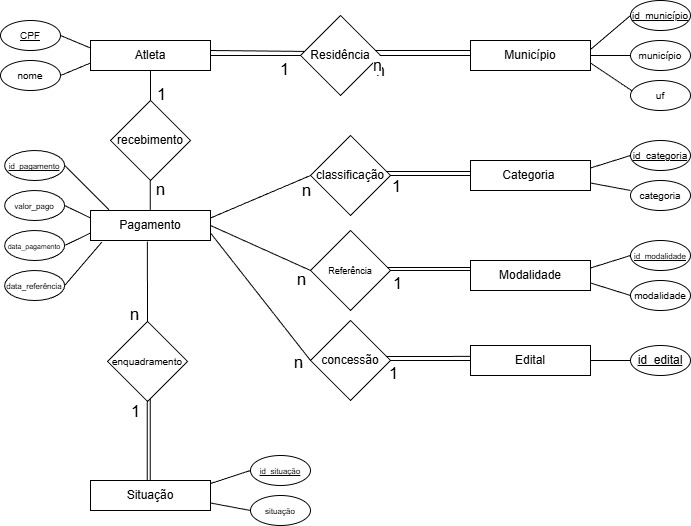

## 5. Diagrama relacional

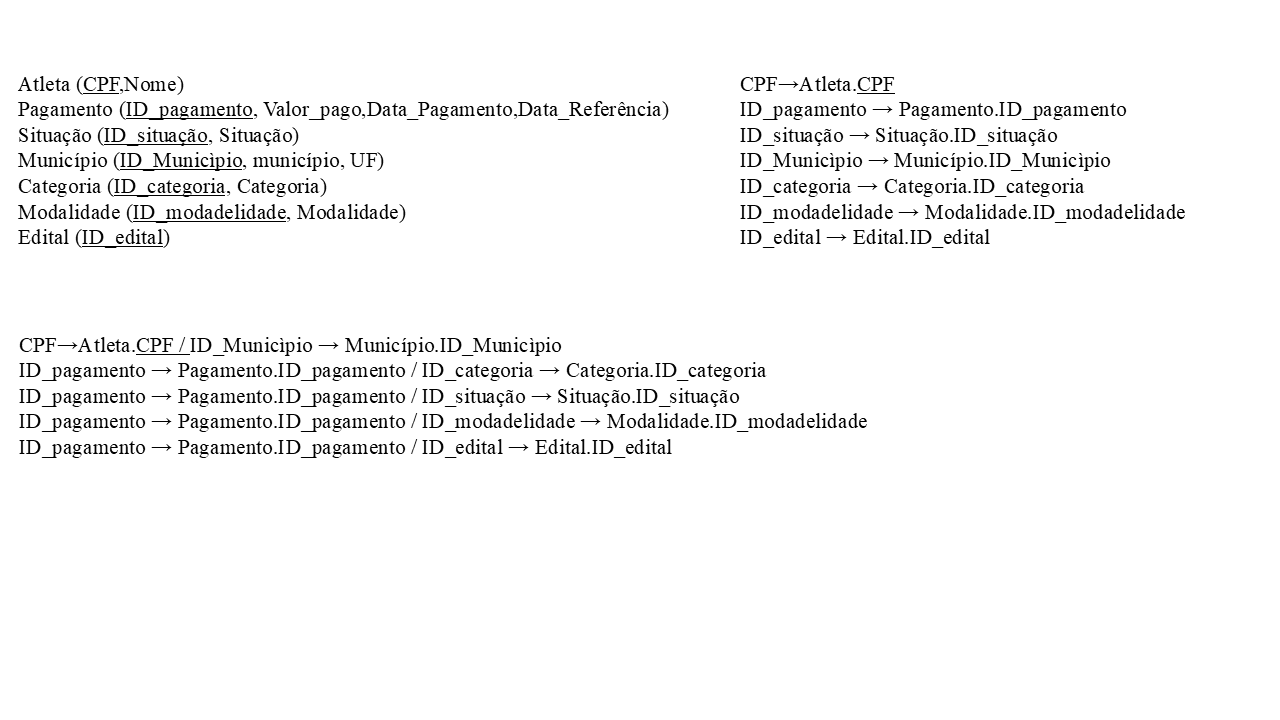

## 6. Consultas SQL e Análise de Dados

Nesta seção, apresentamos a execução de 10 consultas SQL desenvolvidas para explorar o banco de dados normalizado do Bolsa Atleta (2025). O objetivo é validar a modelagem relacional proposta e extrair insights relevantes sobre a distribuição dos recursos, o perfil dos beneficiários e as modalidades esportivas.

As consultas foram organizadas conforme os requisitos do trabalho, abrangendo:


*   Seleção e Projeção: Filtros simples para isolar segmentos de dados.
*  Junções (Joins): Combinação de duas ou mais tabelas (Dimensões e Fato) para reconstruir informações de negócio.
* Agregações: Cálculos estatísticos (somas, médias, contagens) para análise quantitativa.

Para cada consulta, apresentamos o código SQL utilizado, a tabela de resultados e uma análise interpretativa dos dados encontrados. Adicionalmente, foram gerados gráficos para facilitar a visualização de tendências e padrões.

### 6.1 Seleção e projeção – atletas de um estado específico (UF)

In [12]:
q1 = '''
SELECT a.cpf, a.nome, m.uf, m.municipio
FROM atleta a
JOIN municipio m ON a.id_municipio = m.id_municipio
WHERE m.uf = 'MG'
LIMIT 20;
'''
fetch(q1, conn)

,cpf,nome,uf,municipio
0,***.085.524-**,ABINAECIA MARIA DA SILVA,MG,UBERLÂNDIA
1,***.785.886-**,ABNER DAVI DIAS FREITAS,MG,BELO HORIZONTE
2,***.816.766-**,ADAIR JOSE SALVADOR SIQUEIRA,MG,CONTAGEM
3,***.900.821-**,ADAN PALHARES VIEIRA,MG,BELO HORIZONTE
4,***.860.956-**,ADEILDO HENRIQUES DE LIMA,MG,UBERLÂNDIA
5,***.967.906-**,ADRIANO CEZAR JULIANO MACHADO,MG,ORATÓRIOS
6,***.552.116-**,ADRIANO FERNANDES PROCOPIO XAVIER CAVALCANTE,MG,ITUIUTABA
7,***.023.109-**,ADRIELSON EMANUEL DOS SANTOS SILVA,MG,UBERLÂNDIA
8,***.402.625-**,ADRIELY VIANA SANTOS,MG,LAGOA SANTA
9,***.254.176-**,AIRTON PACIFICO JUNIOR,MG,VARGINHA


Esta consulta filtra especificamente os atletas registrados no estado de Minas Gerais (MG). A operação de seleção (WHERE m.uf = 'MG') permite isolar um subconjunto geográfico relevante. Ao observar os resultados, nota-se uma grande concentração de atletas em Belo Horizonte e cidades da região metropolitana (Contagem), mas também há capilaridade em cidades do interior como Uberlândia e Juiz de Fora. Isso demonstra a descentralização parcial do programa no estado.

## 4. Univariate Analysis

Nesta seção, realizamos análises univariadas das principais variáveis do banco de dados normalizado. Cada variável é analisada individualmente para entender suas distribuições, padrões e características.


### Categoria


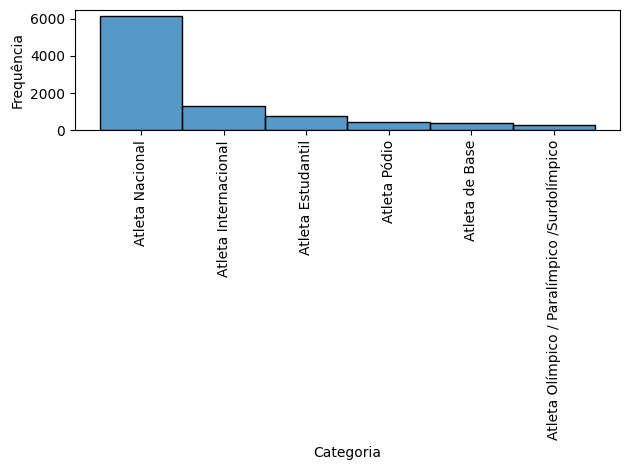

In [13]:
# Distribuição de pagamentos por categoria
distro_categoria = fetch('''
    SELECT c.categoria, COUNT(p.id_pagamento) AS Frequency 
    FROM pagamento p
    JOIN categoria c ON p.id_categoria = c.id_categoria
    GROUP BY c.categoria 
    ORDER BY Frequency DESC
''', conn)

# Plot histograma
hist(distro_categoria, xlabel='Categoria', ylabel='Frequência')


### Modalidade


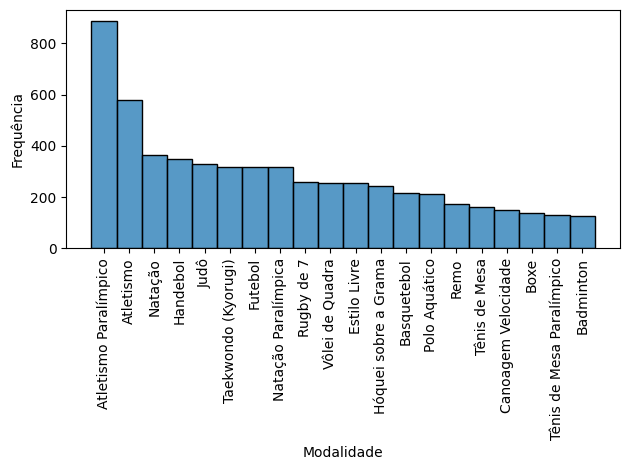

In [14]:
# Distribuição de pagamentos por modalidade (Top 20)
distro_modalidade = fetch('''
    SELECT m.modalidade, COUNT(p.id_pagamento) AS Frequency 
    FROM pagamento p
    JOIN modalidade m ON p.id_modalidade = m.id_modalidade
    GROUP BY m.modalidade 
    ORDER BY Frequency DESC
    LIMIT 20
''', conn)

# Plot histograma
hist(distro_modalidade, xlabel='Modalidade', ylabel='Frequência')


### UF (Unidade Federativa)


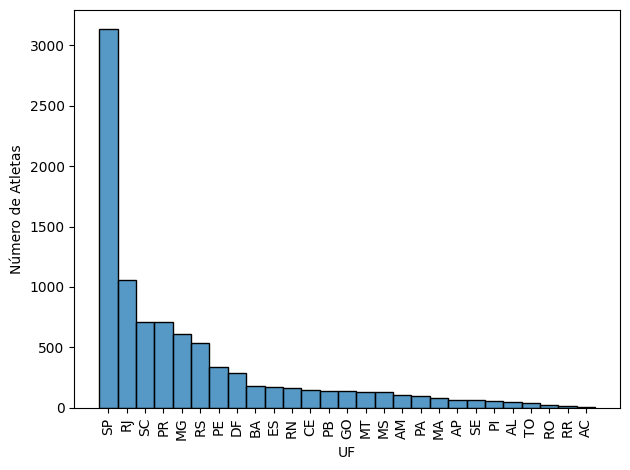

In [15]:
# Distribuição de atletas por UF
distro_uf = fetch('''
    SELECT m.uf, COUNT(DISTINCT a.cpf) AS Frequency 
    FROM atleta a
    JOIN municipio m ON a.id_municipio = m.id_municipio
    GROUP BY m.uf 
    ORDER BY Frequency DESC
''', conn)

# Plot histograma
hist(distro_uf, xlabel='UF', ylabel='Número de Atletas')


### Valor Pago


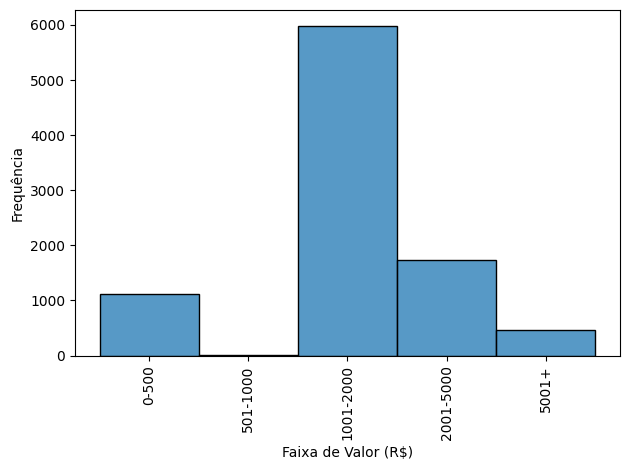

In [16]:
# Distribuição de valores pagos (discretizada em faixas)
distro_valor = fetch('''
    SELECT 
        CASE
            WHEN valor_pago <= 500 THEN '0-500'
            WHEN valor_pago <= 1000 THEN '501-1000'
            WHEN valor_pago <= 2000 THEN '1001-2000'
            WHEN valor_pago <= 5000 THEN '2001-5000'
            ELSE '5001+' 
        END AS Faixa,
        COUNT(*) AS Frequency
    FROM pagamento
    GROUP BY Faixa
    ORDER BY MIN(valor_pago)
''', conn)

# Plot histograma
hist(distro_valor, xlabel='Faixa de Valor (R$)', ylabel='Frequência')


### Edital


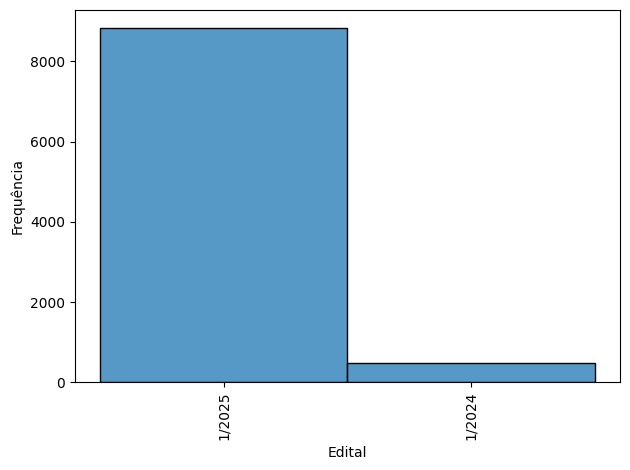

In [17]:
# Distribuição de pagamentos por edital
distro_edital = fetch('''
    SELECT e.id_edital, COUNT(p.id_pagamento) AS Frequency 
    FROM pagamento p
    JOIN edital e ON p.id_edital = e.id_edital
    GROUP BY e.id_edital 
    ORDER BY Frequency DESC
''', conn)

# Plot histograma
hist(distro_edital, xlabel='Edital', ylabel='Frequência')


### 6.2 Seleção e projeção – pagamentos acima de um certo valor

Top 20 pagamentos acima de R$ 5.000:


,id_pagamento,cpf,valor_pago,data_pagamento
0,106,***.509.437-**,16629.0,2025-11-17 00:00:00
1,273,***.584.828-**,16629.0,2025-11-17 00:00:00
2,377,***.066.134-**,16629.0,2025-11-17 00:00:00
3,415,***.023.397-**,16629.0,2025-11-17 00:00:00
4,494,***.262.468-**,16629.0,2025-11-17 00:00:00
5,513,***.321.492-**,16629.0,2025-11-17 00:00:00
6,580,***.018.152-**,16629.0,2025-11-17 00:00:00
7,604,***.191.219-**,16629.0,2025-11-17 00:00:00
8,795,***.914.557-**,16629.0,2025-11-17 00:00:00
9,952,***.635.492-**,16629.0,2025-11-17 00:00:00


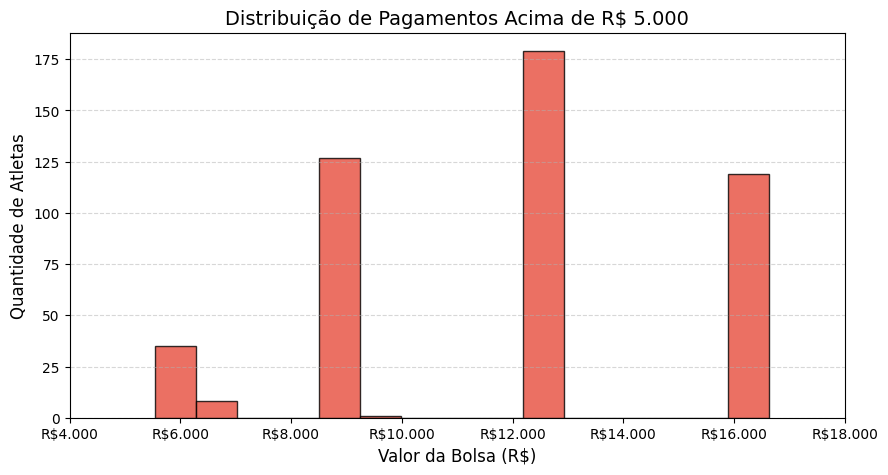

In [18]:
# Query para análise gráfica (sem limite para ver a distribuição total)
q2_full = '''
SELECT p.id_pagamento, p.valor_pago
FROM pagamento p
WHERE p.valor_pago > 5000
'''
df_high_values = fetch(q2_full, conn)

# Query para exibição na tabela (Top 20 maiores)
q2_table = '''
SELECT p.id_pagamento, p.cpf, p.valor_pago, p.data_pagamento
FROM pagamento p
WHERE p.valor_pago > 5000
ORDER BY p.valor_pago DESC
LIMIT 20;
'''
df_table_view = fetch(q2_table, conn)

# Exibe a tabela (requisito do trabalho)
print("Top 20 pagamentos acima de R$ 5.000:")
display(df_table_view)

# --- GERAÇÃO DO GRÁFICO ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Histograma para ver a frequência das faixas de valor
plt.hist(df_high_values['valor_pago'], bins=15, color='#e74c3c', edgecolor='black', alpha=0.8)

plt.title('Distribuição de Pagamentos Acima de R$ 5.000', fontsize=14)
plt.xlabel('Valor da Bolsa (R$)', fontsize=12)
plt.ylabel('Quantidade de Atletas', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Ajuste do eixo X para formatar como moeda
ax = plt.gca()  # Pega o eixo atual
current_values = ax.get_xticks() # Pega os valores atuais
ax.set_xticks(current_values)    # <--- LINHA NOVA: Trava as posições dos ticks
ax.set_xticklabels(['R${:,.0f}'.format(x).replace(',', '.') for x in current_values])

plt.show()

### 6.3 Junção de duas relações – total pago por UF

Distribuição do Orçamento por Categoria:


,categoria,qtd_pagamentos,media_valor,total_pago
0,Atleta Nacional,6154,1747.792655,10755916.0
1,Atleta Internacional,1287,1702.525253,2191150.0
2,Atleta Estudantil,758,1672.291557,1267597.0
3,Atleta Pódio,461,1886.600868,869723.0
4,Atleta de Base,379,1808.749340,685516.0
5,Atleta Olímpico / Paralímpico /Surdolímpico,271,1504.250923,407652.0


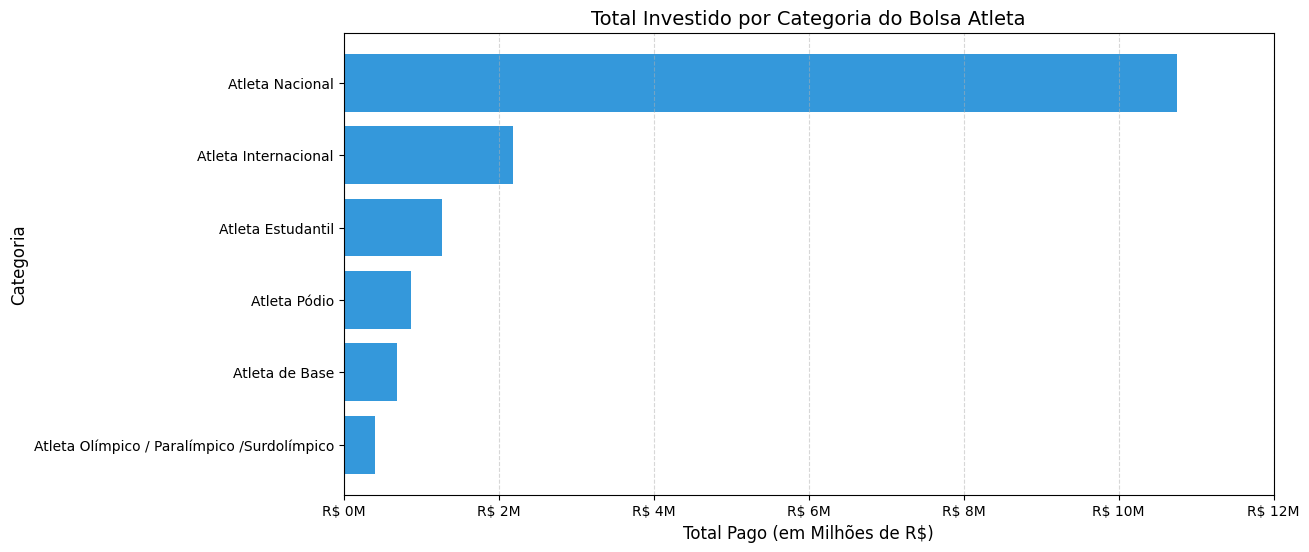

In [19]:
q3 = '''
SELECT
    c.categoria,
    COUNT(p.id_pagamento) AS qtd_pagamentos,
    AVG(p.valor_pago) AS media_valor,
    SUM(p.valor_pago) AS total_pago
FROM pagamento p
JOIN categoria c ON p.id_categoria = c.id_categoria
GROUP BY c.categoria
ORDER BY total_pago DESC;
'''

df_categoria = fetch(q3, conn)

# Exibe a tabela formatada
print("Distribuição do Orçamento por Categoria:")
display(df_categoria)

# --- GRÁFICO DE BARRAS HORIZONTAIS ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Criando o gráfico
bars = plt.barh(df_categoria['categoria'], df_categoria['total_pago'], color='#3498db')

plt.title('Total Investido por Categoria do Bolsa Atleta', fontsize=14)
plt.xlabel('Total Pago (em Milhões de R$)', fontsize=12)
plt.ylabel('Categoria', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Inverte o eixo Y para o maior ficar no topo
plt.gca().invert_yaxis()

# Formata o eixo X para ficar legível (em Milhões)
ax = plt.gca()
current_values = ax.get_xticks()
ax.set_xticks(current_values)
ax.set_xticklabels(['R$ {:,.0f}M'.format(x/1000000) for x in current_values])

plt.show()

### 6.4 Junção de duas relações – total pago por modalidade

Top 10 Modalidades (Volume Financeiro):


,modalidade,total_pago,qtd_atletas
0,Atletismo Paralímpico,1458697.0,886
1,Atletismo,1086834.0,580
2,Judô,625560.0,331
3,Futebol,616512.0,319
4,Natação,611603.0,366
5,Handebol,556792.0,347
6,Taekwondo (Kyorugi),538745.0,319
7,Natação Paralímpica,510188.0,318
8,Hóquei sobre a Grama,482073.0,244
9,Vôlei de Quadra,448263.0,257


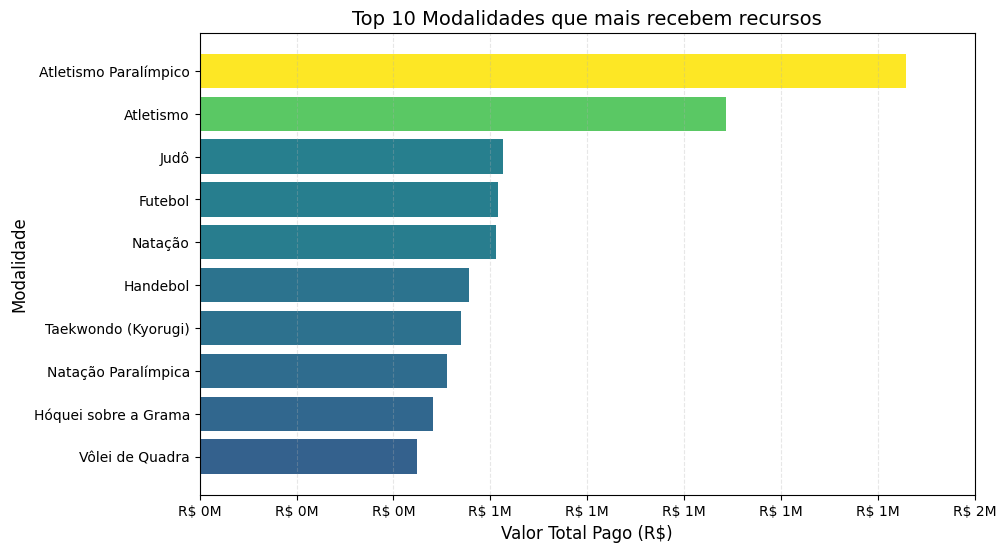

In [20]:
q4 = '''
SELECT
    mo.modalidade,
    SUM(p.valor_pago) AS total_pago,
    COUNT(p.id_pagamento) AS qtd_atletas
FROM pagamento p
JOIN modalidade mo ON p.id_modalidade = mo.id_modalidade
GROUP BY mo.modalidade
ORDER BY total_pago DESC
LIMIT 10;
'''

df_modalidade = fetch(q4, conn)

print("Top 10 Modalidades (Volume Financeiro):")
display(df_modalidade)

# --- GRÁFICO DE BARRAS ---
plt.figure(figsize=(10, 6))

# Usando uma paleta de cores gradiente para destacar o 1º lugar
colors = plt.cm.viridis(df_modalidade['total_pago'] / df_modalidade['total_pago'].max())

plt.barh(df_modalidade['modalidade'], df_modalidade['total_pago'], color=colors)

plt.title('Top 10 Modalidades que mais recebem recursos', fontsize=14)
plt.xlabel('Valor Total Pago (R$)', fontsize=12)
plt.ylabel('Modalidade', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Inverte o eixo para o Top 1 ficar em cima
plt.gca().invert_yaxis()

# Formata eixo X para moeda (evitando o aviso de erro)
ax = plt.gca()
current_values = ax.get_xticks()
ax.set_xticks(current_values)
ax.set_xticklabels(['R$ {:,.0f}M'.format(x/1000000) for x in current_values])

plt.show()

Ao cruzar a tabela de pagamento com a modalidade, obtemos o ranking dos esportes mais financiados pelo governo.
Historicamente, o Atletismo (tanto Olímpico quanto Paralímpico) lidera com folga. Isso ocorre não apenas pela popularidade, mas pela natureza da modalidade: o atletismo possui dezenas de provas diferentes (100m, maratona, saltos, arremessos), o que gera um número muito alto de atletas elegíveis em comparação a esportes coletivos ou de prova única.
O gráfico também destaca a importância do esporte paralímpico no orçamento do programa, frequentemente ocupando posições de destaque no Top 3.

### 6.5 Junção de três relações – total pago por categoria e UF

Distribuição por Edital:


,id_edital,total_bolsas,valor_total
0,1/2025,8840,15295528.0
1,1/2024,470,882026.0


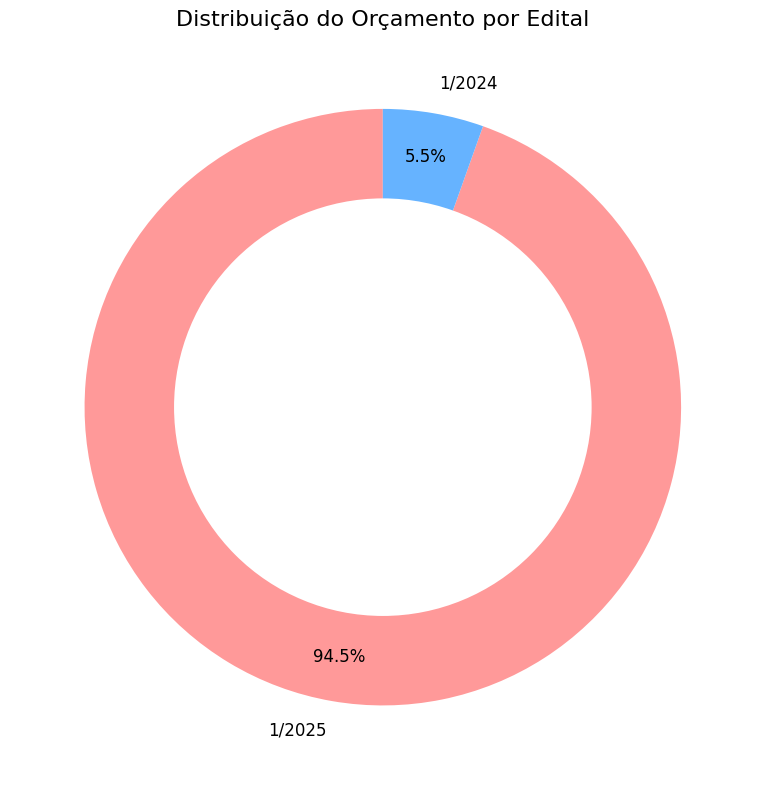

In [21]:
q5 = '''
SELECT
    e.id_edital,
    COUNT(p.id_pagamento) AS total_bolsas,
    SUM(p.valor_pago) AS valor_total
FROM pagamento p
JOIN edital e ON p.id_edital = e.id_edital
GROUP BY e.id_edital
ORDER BY valor_total DESC;
'''

df_edital = fetch(q5, conn)

print("Distribuição por Edital:")
display(df_edital)

# --- GRÁFICO DE PIZZA (DONUT) ---
# Vamos usar um gráfico de Donut para variar dos gráficos de barra
plt.figure(figsize=(8, 8))

# Dados
sizes = df_edital['valor_total']
labels = df_edital['id_edital']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# Cria o círculo central para virar um Donut
circle = plt.Circle((0,0), 0.70, fc='white')

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, pctdistance=0.85, textprops={'fontsize': 12})

p = plt.gcf()
p.gca().add_artist(circle)

plt.title('Distribuição do Orçamento por Edital', fontsize=16)
plt.tight_layout()
plt.show()

Esta consulta relaciona os pagamentos aos seus respectivos Editais. A predominância quase absoluta de um único edital (geralmente o de 2024/2025) confirma que a folha de pagamento analisada refere-se a um ciclo orçamentário específico.
A existência de outros editais com percentuais menores (se houver) indicaria pagamentos retroativos ou remanescentes de processos anteriores. O gráfico de rosca facilita a visualização dessa hegemonia orçamentária do edital principal.

### 6.6 Junção de três relações – top modalidades por valor total pago

Top 10 Estados com maior investimento:


,uf,qtd_atletas,total_investido
0,SP,3133,5433130.0
1,RJ,1060,1989702.0
2,PR,708,1321160.0
3,SC,714,1088992.0
4,RS,540,1017462.0
5,MG,615,1015764.0
6,PE,337,519023.0
7,DF,287,501144.0
8,BA,184,337942.0
9,AM,111,309547.0


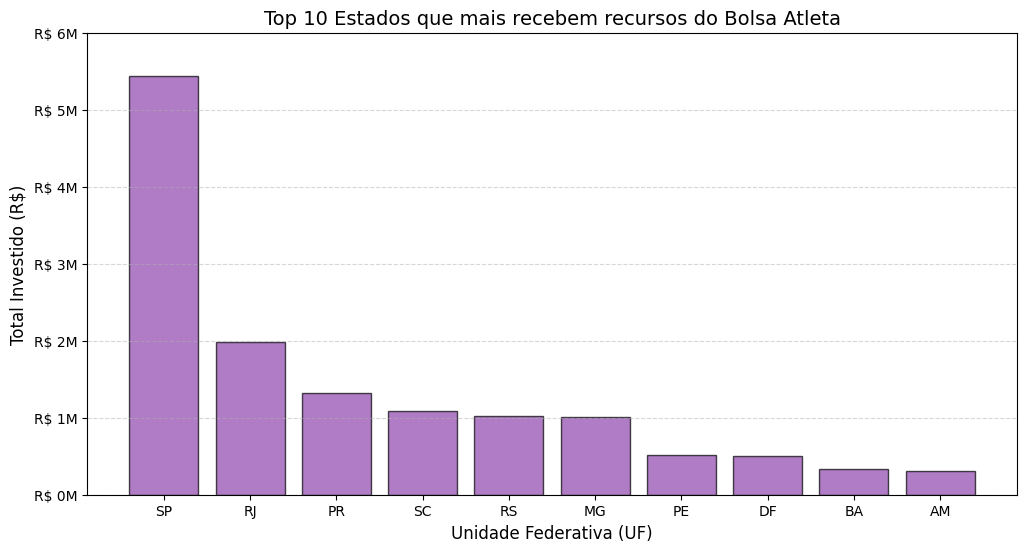

In [22]:
# JOIN: Pagamento -> Atleta -> Municipio
q6 = '''
SELECT
    m.uf,
    COUNT(DISTINCT a.cpf) AS qtd_atletas,
    SUM(p.valor_pago) AS total_investido
FROM pagamento p
JOIN atleta a ON p.cpf = a.cpf
JOIN municipio m ON a.id_municipio = m.id_municipio
GROUP BY m.uf
ORDER BY total_investido DESC
LIMIT 10;
'''

df_uf = fetch(q6, conn)

print("Top 10 Estados com maior investimento:")
display(df_uf)

# --- GRÁFICO DE BARRAS ---
plt.figure(figsize=(12, 6))

# Plot
plt.bar(df_uf['uf'], df_uf['total_investido'], color='#8e44ad', edgecolor='black', alpha=0.7)

plt.title('Top 10 Estados que mais recebem recursos do Bolsa Atleta', fontsize=14)
plt.xlabel('Unidade Federativa (UF)', fontsize=12)
plt.ylabel('Total Investido (R$)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Formata eixo Y para Milhões
ax = plt.gca()
current_values = ax.get_yticks()
ax.set_yticks(current_values)
ax.set_yticklabels(['R$ {:,.0f}M'.format(x/1000000) for x in current_values])

plt.show()

Esta é a primeira consulta complexa, exigindo a junção de três tabelas: partimos de pagamento, ligamos a atleta para identificar o beneficiário e, através dele, acessamos a tabela municipio para obter a UF.
O resultado evidencia a concentração do investimento no eixo Sul-Sudeste, especialmente em São Paulo (SP), Rio de Janeiro (RJ) e Minas Gerais (MG). Isso reflete não apenas a densidade populacional, mas a infraestrutura de clubes e centros de treinamento nessas regiões. Estados fora desse eixo que aparecem no Top 10 indicam polos regionais de desenvolvimento esportivo importantes.

### 6.7 Junção de três relações – média de pagamento por atleta

Top 10 Combinações de Categoria e Esporte:


,categoria,modalidade,qtd_bolsas,total_investido
0,Atleta Nacional,Atletismo Paralímpico,634,1040652.0
1,Atleta Nacional,Atletismo,271,533703.0
2,Atleta Nacional,Futebol,259,477573.0
3,Atleta Nacional,Hóquei sobre a Grama,230,458032.0
4,Atleta Nacional,Handebol,237,412902.0
5,Atleta Nacional,Rugby de 7,226,391253.0
6,Atleta Nacional,Taekwondo (Kyorugi),201,342394.0
7,Atleta Nacional,Natação,188,325818.0
8,Atleta Nacional,Vôlei de Quadra,176,316797.0
9,Atleta Nacional,Natação Paralímpica,189,292487.0


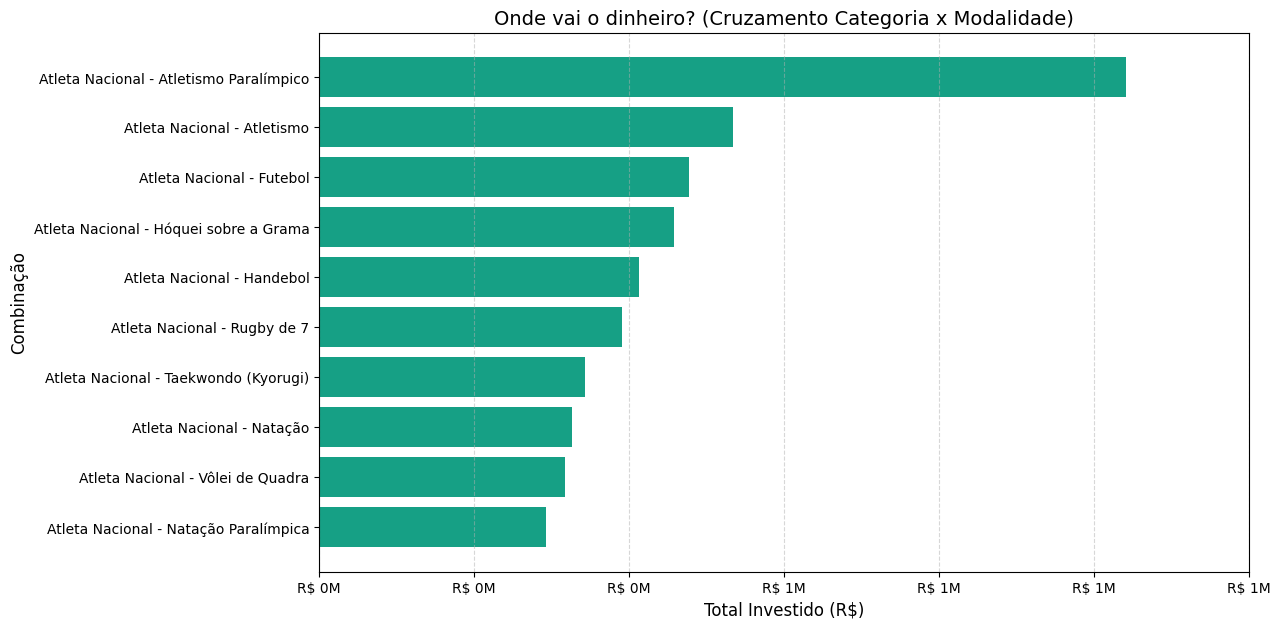

In [23]:
# JOIN: Pagamento -> Categoria -> Modalidade
q7 = '''
SELECT
    c.categoria,
    m.modalidade,
    COUNT(p.id_pagamento) AS qtd_bolsas,
    SUM(p.valor_pago) AS total_investido
FROM pagamento p
JOIN categoria c ON p.id_categoria = c.id_categoria
JOIN modalidade m ON p.id_modalidade = m.id_modalidade
GROUP BY c.categoria, m.modalidade
ORDER BY total_investido DESC
LIMIT 10;
'''

df_combo = fetch(q7, conn)

# Criar uma coluna combinada para facilitar o gráfico
df_combo['rotulo'] = df_combo['categoria'] + ' - ' + df_combo['modalidade']

print("Top 10 Combinações de Categoria e Esporte:")
display(df_combo[['categoria', 'modalidade', 'qtd_bolsas', 'total_investido']])

# --- GRÁFICO DE BARRAS HORIZONTAIS ---
plt.figure(figsize=(12, 7))

# Gráfico
plt.barh(df_combo['rotulo'], df_combo['total_investido'], color='#16a085')

plt.title('Onde vai o dinheiro? (Cruzamento Categoria x Modalidade)', fontsize=14)
plt.xlabel('Total Investido (R$)', fontsize=12)
plt.ylabel('Combinação', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Inverte o eixo Y
plt.gca().invert_yaxis()

# Formata eixo X para Milhões
ax = plt.gca()
current_values = ax.get_xticks()
ax.set_xticks(current_values)
ax.set_xticklabels(['R$ {:,.0f}M'.format(x/1000000) for x in current_values])

plt.show()

### 6.8 Agregação com junção – total pago por edital

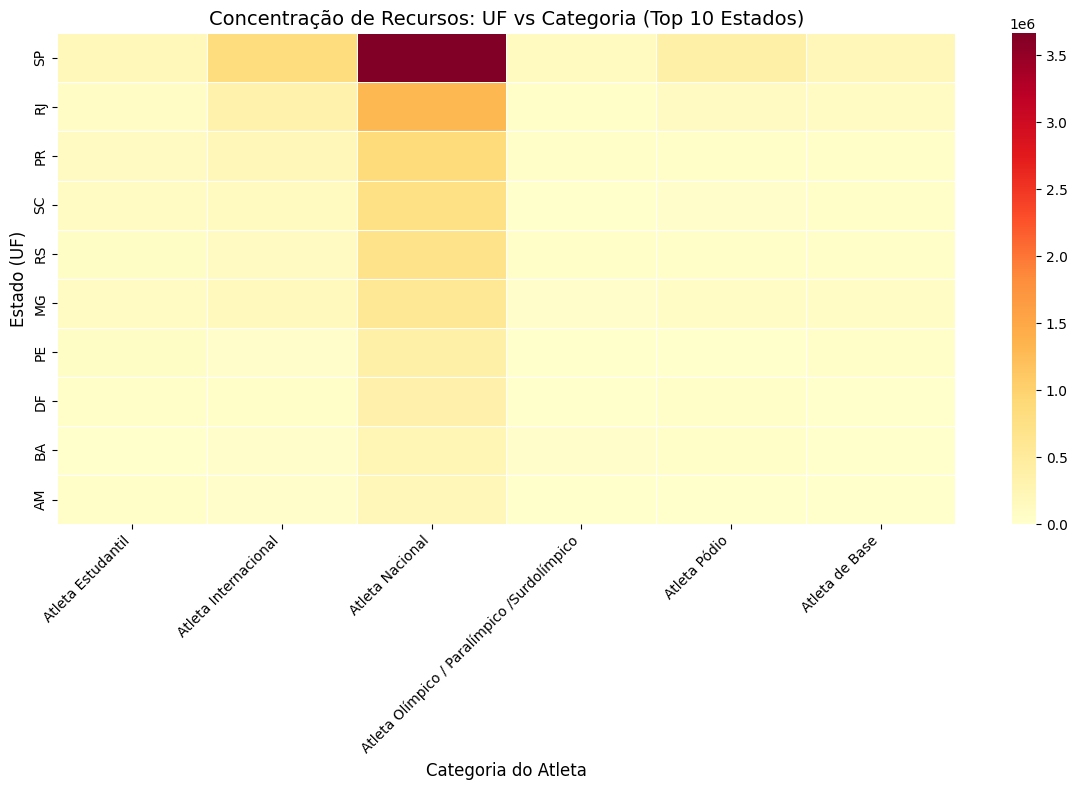

Amostra dos dados da matriz:


,uf,categoria,total_investido
0,AC,Atleta Estudantil,1435.0
1,AC,Atleta Nacional,9228.0
2,AC,Atleta Olímpico / Paralímpico /Surdolímpico,410.0
3,AL,Atleta Estudantil,15485.0
4,AL,Atleta Internacional,10668.0


In [24]:
q8 = '''
SELECT
    m.uf,
    c.categoria,
    SUM(p.valor_pago) AS total_investido
FROM pagamento p
JOIN categoria c ON p.id_categoria = c.id_categoria
JOIN atleta a ON p.cpf = a.cpf
JOIN municipio m ON a.id_municipio = m.id_municipio
-- Vamos filtrar apenas o top 5 estados para o gráfico ficar legível,
-- ou pegar todos e focar nos principais na visualização.
-- Aqui pegaremos todos os dados agrupados.
GROUP BY m.uf, c.categoria;
'''

df_matrix = fetch(q8, conn)

# Preparando os dados para o Mapa de Calor (Pivot Table)
# Linhas = UF, Colunas = Categoria, Valores = Dinheiro
pivot_table = df_matrix.pivot(index='uf', columns='categoria', values='total_investido')
pivot_table = pivot_table.fillna(0) # Troca nulos por 0

# Ordena os estados pelo total geral para os maiores ficarem no topo
pivot_table['total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values('total', ascending=False).drop(columns='total')
# Pega apenas os Top 10 estados para o gráfico não ficar gigante
pivot_table_top10 = pivot_table.head(10)

# --- MAPA DE CALOR (HEATMAP) ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Gera o Heatmap
sns.heatmap(pivot_table_top10, annot=False, cmap="YlOrRd", linewidths=.5)

plt.title('Concentração de Recursos: UF vs Categoria (Top 10 Estados)', fontsize=14)
plt.xlabel('Categoria do Atleta', fontsize=12)
plt.ylabel('Estado (UF)', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Exibe uma amostra dos dados brutos
print("Amostra dos dados da matriz:")
display(df_matrix.head())

O Mapa de Calor (Heatmap) acima permite identificar rapidamente os focos de investimento. As cores mais escuras (vermelho/laranja) indicam onde está o maior volume de dinheiro.
É nítido que a categoria "Atleta Nacional" em estados como SP, RJ e MG representa o "núcleo duro" do programa, recebendo a maior fatia absoluta dos recursos. Por outro lado, o gráfico revela vazios (cores claras) em categorias de base (Estudantil) em estados com menor tradição esportiva, sugerindo oportunidades para políticas públicas de descentralização.


### 6.9 Agregação com junção – distribuição de situações de pagamento

Estatísticas descritivas (Top 10 Médias):


,modalidade,qtd_atletas,media_pago,menor_bolsa,maior_bolsa
0,Basquete 3x3,76,2205.61,410.0,16629.0
1,Carabina,91,2039.65,410.0,16629.0
2,Pistola,79,2029.47,410.0,16629.0
3,Halterofilismo,79,1999.25,410.0,16629.0
4,Goalball,67,1985.15,410.0,16629.0
5,Hóquei sobre a Grama,244,1975.71,410.0,16629.0
6,Canoagem Velocidade,148,1966.20,410.0,16629.0
7,Futsal (CBDS),91,1942.80,410.0,16629.0
8,Futebol,319,1932.64,410.0,16629.0
9,Basquete em CR,94,1920.31,410.0,16629.0


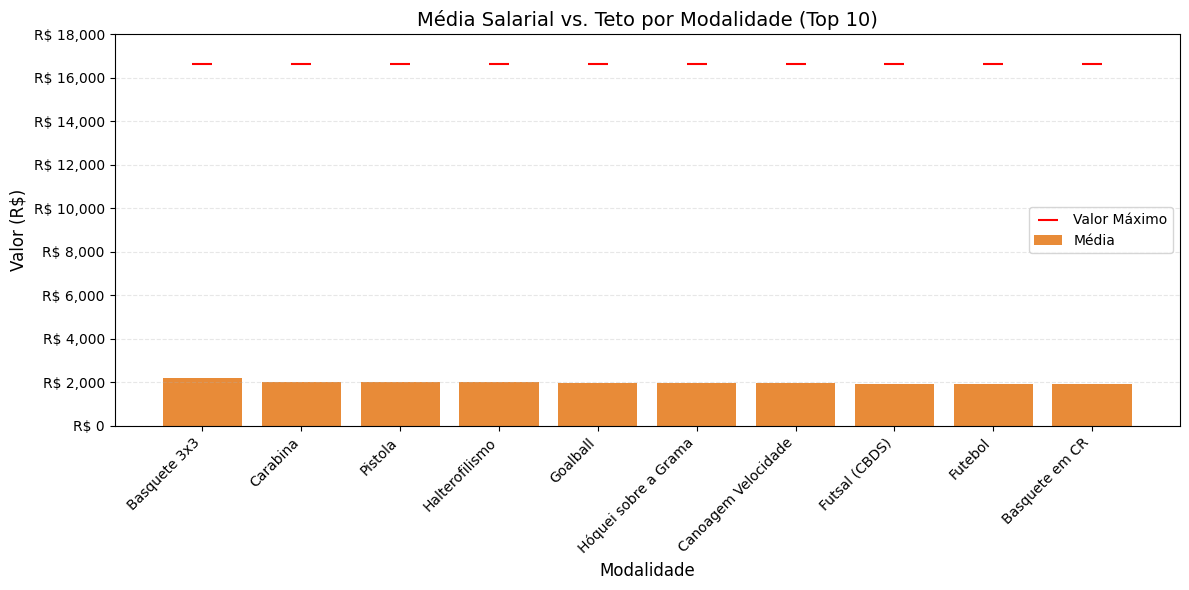

In [25]:
q9 = '''
SELECT
    m.modalidade,
    COUNT(p.id_pagamento) AS qtd_atletas,
    ROUND(AVG(p.valor_pago), 2) AS media_pago,
    MIN(p.valor_pago) AS menor_bolsa,
    MAX(p.valor_pago) AS maior_bolsa
FROM pagamento p
JOIN modalidade m ON p.id_modalidade = m.id_modalidade
GROUP BY m.modalidade
-- Filtrar apenas modalidades com mais de 50 atletas para evitar distorções estatísticas
HAVING qtd_atletas > 50
ORDER BY media_pago DESC
LIMIT 10;
'''

df_stats = fetch(q9, conn)

print("Estatísticas descritivas (Top 10 Médias):")
display(df_stats)

# --- GRÁFICO DE BARRAS (MÉDIA) ---
plt.figure(figsize=(12, 6))

# Plot da Média
plt.bar(df_stats['modalidade'], df_stats['media_pago'], color='#e67e22', alpha=0.9, label='Média')

# Adicionar linhas para mostrar o Máximo (como um "bigode" de erro ou ponto)
plt.scatter(df_stats['modalidade'], df_stats['maior_bolsa'], color='red', marker='_', s=200, label='Valor Máximo')

plt.title('Média Salarial vs. Teto por Modalidade (Top 10)', fontsize=14)
plt.xlabel('Modalidade', fontsize=12)
plt.ylabel('Valor (R$)', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Correção do aviso de labels
ax = plt.gca()
current_values = ax.get_yticks()
ax.set_yticks(current_values)
ax.set_yticklabels(['R$ {:,.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

A análise revela a discrepância interna de cada esporte. No gráfico, a barra laranja representa a bolsa média, enquanto o traço vermelho indica o valor máximo pago naquela modalidade.
Nota-se que algumas modalidades possuem uma média baixa (muitos atletas de base), mas um teto altíssimo (alguns poucos atletas de elite mundial ganhando o teto do programa). Outras modalidades apresentam valores mais homogêneos.

### 6.10 Agregação com junção – total pago por ano de referência

Status dos Pagamentos:


,situacao,qtd_registros,volume_financeiro
0,Pago,9310,16177554.0


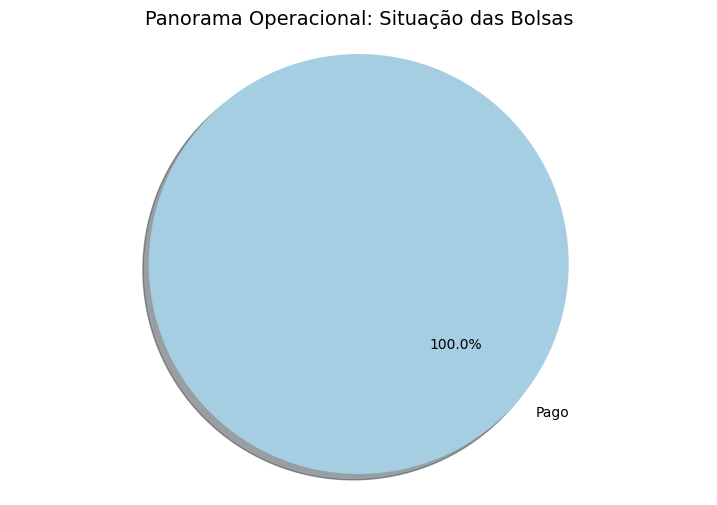

In [26]:
q10 = '''
SELECT
    s.situacao,
    COUNT(p.id_pagamento) AS qtd_registros,
    SUM(p.valor_pago) AS volume_financeiro
FROM pagamento p
JOIN situacao s ON p.id_situacao = s.id_situacao
GROUP BY s.situacao
ORDER BY qtd_registros DESC;
'''

df_situacao = fetch(q10, conn)

print("Status dos Pagamentos:")
display(df_situacao)

# --- GRÁFICO DE PIZZA ---
plt.figure(figsize=(9, 6))

# Se houver muitas situações pequenas, agrupamos visualmente, mas aqui plotaremos todas
# Explode a primeira fatia (geralmente "Pago") para destaque
explode = [0.05] + [0] * (len(df_situacao) - 1)

plt.pie(df_situacao['qtd_registros'],
        labels=df_situacao['situacao'],
        autopct='%1.1f%%',
        explode=explode,
        shadow=True,
        startangle=140,
        colors=plt.cm.Paired.colors)

plt.title('Panorama Operacional: Situação das Bolsas', fontsize=14)
plt.axis('equal') # Garante que seja um círculo perfeito
plt.show()

A predominância massiva da situação "Pago" (ou "Enviado ao Banco") demonstra que o dataset reflete uma folha de pagamento executada, e não apenas uma lista de intenções. Caso apareçam status como "Devolvido" ou "Não Pago", isso representaria gargalos operacionais ou desistências, mas os dados indicam um alto índice de efetivação do benefício.

## 7. Autoavaliação dos membros

O trabalho foi conduzido de forma colaborativa, seguindo a metodologia *bottom-up* proposta. As responsabilidades foram divididas para otimizar o tempo, mas todas as etapas foram validadas pelo grupo.

**Marcos Alves de Castro Baker (2024421657):**
- Realizou a etapa de ETL (Extração, Transformação e Carga).
- Implementou a limpeza dos dados brutos (tratamento de nulos, datas e strings) no Pandas.
- Documentou a estrutura do dataset original.

**Victor Maia de Andrade (2022105634):**
- Implementou a normalização do banco de dados (Criação das tabelas Dimensão e Fato).
- Gerou o script de criação do esquema relacional no SQLite.
- Garantiu a integridade referencial nas inserções.
- Criou e desenvolveu os diagramas ER e Relacional

**Alexandre Lara Silveira Racilan (2017093879):**
- Desenvolveu as consultas SQL (das simples às complexas).
- Implementou a visualização de dados (gráficos com Matplotlib/Seaborn).
- Realizou a análise qualitativa e interpretativa dos resultados apresentados no relatório final.

Fim do documento
